In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob

In [134]:
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates

import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits

from    astropy.table           import  Table, join, vstack, unique
from    astropy.coordinates     import  SkyCoord
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget              import  targetmask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import  make_axes_locatable
from    itertools               import  combinations

In [4]:
##  DR7 cutouts
import  requests

from    PIL                     import  Image
from    io                      import  BytesIO

In [7]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]

##  DR7 cutouts 

In [9]:
def get_dr7cutout(ra, dec):
  nim         = len(ra)
  nrow        =  np.maximum(np.floor(nim / 5).astype(np.int), 1)

  fig, axes   = plt.subplots(nrow, 5, figsize=(20, 5 * nrow))

  row         = 0
  col         = 0

  nmax        = np.minimum(5 * nrow, nim)
  
  for i in range(nmax):        
    url       = 'http://legacysurvey.org/viewer/jpeg-cutout?ra={:.4f}&dec={:.4f}&layer=decals-dr7&pixscale=0.27&bands=grz'.format(ra[i], dec[i])
    response  = requests.get(url)
    img       = Image.open(BytesIO(response.content))

    axes[row, col].imshow(img)
    
    col      += 1
    
    if col > 4:
        row  += 1
        col   = 0 

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

#  Summary 

In [10]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
root = '/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/v1/'

## Prep. redrock templates

In [11]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## GET GAMA G12 TRUTH TABLES

In [12]:
GAMA  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/GAMA-DR3-SpecObj-match.fits')
LGAMA = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits')

In [13]:
# Table(LGAMA)

In [14]:
# Table(GAMA)

In [15]:
# plt.rcParams['figure.figsize'] = [10, 10]
# pl.plot(GAMA['RA'], GAMA['DEC'], '.')

In [16]:
##  Restrict to G12
isin = (GAMA['RA'] < 200.) & (GAMA['RA'] > 150.)

G12  =   GAMA[isin]
LG12 =  LGAMA[isin]

In [17]:
# plt.rcParams['figure.figsize'] = [10, 10]
# pl.plot(G12['RA'], G12['DEC'], '.')

##  GET SDSS redshifts  

In [18]:
SDSS  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/sdss-specObj-dr14-unique-trimmed-match.fits')
LSDSS = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-sdss-specObj-dr14-unique-trimmed-match.fits')

##  Aaron's GFA Telemetry

In [103]:
file      = fits.open('/global/cfs/cdirs/desi/users/ameisner/GFA/minisv2/gfa_reduce_ccds_minisv2-thru_20200304.fits')
# file[1].header

In [131]:
telemetry = Table(file[1].data)  
original  = telemetry.columns

keep      = ['CAMERA', 'EXPID', 'MJD', 'PROGRAM', 'SKY_MAG_AB', 'PETAL_LOC',\
             'MOONRA', 'MOONDEC', 'AIRMASS', 'FIBER_FRACFLUX',\
             'MOON_SEP_DEG', 'TRANSPARENCY', 'FWHM_ASEC']

telemetry = telemetry[keep]

telemetry.sort('MJD')

telemetry = unique(telemetry, keys='EXPID')

# Guider and spectro. one step out.
telemetry['EXPID'] += 1 
telemetry

CAMERA,EXPID,MJD,PROGRAM,SKY_MAG_AB,PETAL_LOC,MOONRA,MOONDEC,AIRMASS,FIBER_FRACFLUX,MOON_SEP_DEG,TRANSPARENCY,FWHM_ASEC
str6,int64,float64,str94,float64,uint8,float64,float64,float64,float64,float64,float64,float64
GUIDE2,50987,58899.13338672,system test,21.1566682535317,2,293.097195,-23.012979,1.044303,0.5727246366725838,162.78977449589493,0.9900119796663759,1.114202847480774
GUIDE2,50989,58899.14650581,MiniSVtile70004ELG,21.071253750058602,2,293.276637,-23.001257,1.106017,0.6136458324385117,177.41248889593683,0.9624556666021803,1.044660391807556
GUIDE0,50992,58899.17208648,system test,21.20931821148397,0,293.625866,-22.977856,1.008331,0.5483661412825026,164.36843952173774,0.9589069828393624,1.1055099916458129
GUIDE0,50996,58899.1864734,MiniSVtile70004ELG,21.178416546832295,0,293.814529,-22.964892,1.035258,0.6542807032343431,175.86718743672762,0.9642008939385502,1.0234113407135008
GUIDE0,50997,58899.20108672,MiniSVtile70004ELG,21.199581019199915,0,294.012542,-22.951042,1.023814,0.6594286047055522,175.9499889953227,0.9532440515391543,0.9529032945632934
GUIDE0,51002,58899.22943358,MiniSVtile70004ELG,21.30038947571488,0,294.398892,-22.9233,1.022187,0.6962262346340398,176.09087268350055,0.9603123598322053,0.9480739736557007
GUIDE2,51003,58899.24666779,MiniSVtile70004ELG,21.403615928558786,2,294.63431,-22.905932,1.034062,0.7153119797087335,177.67456911373264,0.957696274106696,0.8804632854461669
GUIDE0,51015,58899.27335233,MiniSVtile70005ELG,21.37255988056843,0,295.001314,-22.878152,1.065431,0.4695072029925492,141.0291432388534,1.110469525687953,nan
GUIDE0,51029,58899.29514231,MiniSVtile70005ELG,21.395104770930566,0,295.292819,-22.855477,1.030254,0.6204949096485857,141.28891211165202,1.2188446520319778,0.9828450059890746


##  Rongpu cframe Table 

In [107]:
# ALL EXPIDS
cframes    = Table(fits.open('/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes.fits')[1].data)

del  cframes['cframe']

cols       = list(cframes.columns)

for x in cols:
    cframes.rename_column(x, x.upper())

new       = telemetry.columns
keep      = [x not in cframes.columns for x in new]  
  
new       = ['EXPID'] + [x for i, x in enumerate(new) if keep[i]]

telemetry = telemetry[new]

cframes   = join(cframes, telemetry, keys='EXPID', join_type='left')

keep      = (cframes['CAMERA'] == 'b') & (cframes['SPECTROGRAPH'] == 0)

cframes   =  cframes[keep]
cframes

NIGHT,MJD,LAT,LON,ELV,TILEID,EXPID,EXPTIME,CAMERA,PETAL_LOC,SPECTROGRAPH,RA,DEC,MOONALT,MOONRA,MOONDEC,MOONFRAC,MOONSEP,SUNALT,SUNRA,SUNDEC,SUNSEP,PROGRAM,SKY_MAG_AB,AIRMASS,FIBER_FRACFLUX,MOON_SEP_DEG,TRANSPARENCY,FWHM_ASEC
str8,float64,float64,float64,float64,int64,int64,float64,str1,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str94,float64,float64,float64,float64,float64,float64
20200225,58905.25690431,31.96403,-111.59989,2097.0,70502,52090,900.0,b,-1,0,180.012,-0.510261,-34.718479928578454,6.5807555865875145,-2.851443373246277,0.0627905403740725,172.62306389652935,-58.98578687979692,338.81845580446975,-8.902828361677603,156.884725513756,SV tile 70508 M67),21.31417205487861,1.066505,0.10354866297714563,126.08034913225622,0.8292286236725607,nan
20200225,58905.29573492,31.96403,-111.59989,2097.0,70502,52112,900.0,b,-1,0,180.006929,-0.50838,-44.78365842537352,7.1329206177420295,-2.665919591058877,0.06456711009394417,172.20096734808536,-65.6478509433898,338.855669375522,-8.888320132355824,156.92963243536897,--,--,--,--,--,--,--
20200225,58905.31193004,31.96403,-111.59989,2097.0,70502,52113,900.0,b,-1,0,180.005321,-0.50784,-48.58731905716733,7.370947675013313,-2.589179006361515,0.06531494808352112,172.01170605260654,-66.79688683727188,338.8711961559938,-8.882273782326221,156.94780317941476,SV tile 70502,21.176923273439897,1.376164,0.15249149984210386,172.97440809602432,0.8852207478147045,2.7088464879989624
20200225,58905.32773044,31.96403,-111.59989,2097.0,70502,52114,900.0,b,-1,0,180.00393,-0.507439,-51.96889448882187,7.606742043392503,-2.514662923499652,0.06604845305372314,171.8204720353583,-66.72988268151406,338.8863448499122,-8.876377468474542,156.96531651724945,SV tile 70502,21.071496839029514,1.304497,0.14644674351229756,171.00976615809708,0.8774751426443095,2.5958403396606444
20200225,58905.34240863,31.96403,-111.59989,2097.0,70502,52115,900.0,b,-1,0,180.002758,-0.50717,-54.73337940443868,7.828433739857344,-2.445743920701462,0.0667333011269644,171.63759718837352,-65.62119271505925,338.90041609599945,-8.87090229202459,156.98143151473826,SV tile 70502,21.254025770234627,1.253326,0.1337792821057148,170.3599328540935,0.9158872420565488,2.4944244050979614
20200225,58905.35785641,31.96403,-111.59989,2097.0,70502,52116,900.0,b,-1,0,180.00163,-0.506989,-57.14499284187054,8.063952927010664,-2.3735160887221465,0.06745762823660251,171.44036306217538,-63.50832833682916,338.91522166042625,-8.865142465161185,156.9982492040612,SV tile 70502,21.27567026725024,1.219535,0.14078838265234425,170.7814531851798,0.8743178713758041,2.719471111297607
20200227,58907.37620341,31.96403,-111.59989,2097.0,70502,52446,500.0,b,-1,0,180.000408,-0.5069,-42.65401227235271,29.885620881850883,6.875194827651015,0.1910029866659932,149.5211184486977,-59.37159011506509,340.8186733175566,-8.107452596298964,159.02826419383337,MW/BGS tile 70502 (1 of 2),20.80459461622589,1.185443,0.5627372381449223,149.3444303731615,0.10385493210701058,1.1006806707382202
20200227,58907.38710085,31.96403,-111.59989,2097.0,70502,52447,500.0,b,-1,0,179.999229,-0.50693,-44.57128735351031,30.05169425071087,6.920912168636366,0.19181133310720833,149.34945863926703,-56.96432409303994,340.82905729493154,-8.103346850844785,159.0403886534902,--,--,--,--,--,--,--
20200227,58907.39358829,31.96403,-111.59989,2097.0,70502,52448,500.0,b,-1,0,179.999229,-0.50693,-45.614161617122875,30.15125065421643,6.948270595510768,0.192293202118483,149.2472546715975,-55.429905020523655,340.8352370111299,-8.100903113217594,159.04697412399105,MW/BGS tile 70502 (1 of 2),20.920287792134406,1.188351,0.6591741292727353,147.71047262132095,0.2994467891247417,0.8563166809082031


In [108]:
# cframes    = cframes[cframes['night'] == '20200229']
# cframes

In [109]:
# BGS EXPIDS:  defined by night and tile.
bgs_expids = cframes['EXPID']
nights     = cframes['NIGHT'] 
tiles      = cframes['TILEID']
petals     = cframes['PETAL_LOC']

##  Unique tiles and nights.

In [110]:
samples = OrderedDict(set(zip(nights, tiles)))
order   = np.sort([np.int(x) for x in samples.keys()]).astype(str)

samples = OrderedDict(zip(order, [samples[x] for x in order]))
samples = list(zip(samples.keys(), samples.values()))
samples

[('20200225', 70502),
 ('20200227', 70502),
 ('20200228', 70500),
 ('20200303', 70500)]

In [111]:
attributes = ['MOONALT', 'MOONRA', 'MOONDEC', 'MOONFRAC', 'MOONSEP', 'SUNALT',\
              'SUNRA', 'SUNDEC', 'SUNSEP', 'SKY_MAG_AB', 'AIRMASS', 'EXPTIME',\
              'FIBER_FRACFLUX', 'MOON_SEP_DEG', 'TRANSPARENCY', 'FWHM_ASEC']

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

##  NUMBER OF FIBER REACH ERRORS FOR ALL TARGETS ON PLATE

##   GET COADDED EXPOSURES AND ZBEST FILES

In [25]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_FLUX'           / extension name                                 
# BUNIT   = '10**-17 erg/(s cm2 Angstrom)'                                        
# CHECKSUM= '1gAq4f6n1fAn1f3n'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '1442897442'         / data unit checksum updated 2020-02-26T06:51:09 

In [26]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_IVAR'           / extension name                                 
# BUNIT   = '10**+34 (s2 cm4 Angstrom2) / erg2'                                   
# CHECKSUM= '4aSk6XPj4aPj4WPj'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '966772586'          / data unit checksum updated 2020-02-26T06:51:09 

In [112]:
utiles                     = np.unique(tiles)

# np.unique(petals)
upetals                    = np.array([0,3,6,7,9])

unights                    = np.unique(nights)

In [113]:
fpath                      = root + '/NEXP1/{}/{}/coadd-{}-6-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
wave                       = fitsio.read(fpath, ext=2)

In [114]:
fpath                      = root + '/NEXP1/{}/{}/coadd-{}-6-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
scores                     = fits.open(fpath)[7]
scores.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   72 / length of dimension 1                          
NAXIS2  =                  500 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    9 / number of table fields                         
TTYPE1  = 'INTEG_COADD_FLUX_B' / integ. flux in wave. range 4000,5800A          
TFORM1  = 'D       '                                                            
TTYPE2  = 'MEDIAN_COADD_FLUX_B' / median flux in wave. range 4000,5800A         
TFORM2  = 'D       '                                                            
TTYPE3  = 'MEDIAN_COADD_SNR_

In [115]:
print(fpath)

/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/v1//NEXP1/70500/20200303/coadd-20200303-6-00052933.fits


In [75]:
bandpasses                 = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}

fpath                      = root + '/NEXP1/{}/{}/coadd-{}-6-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
wave                       = fitsio.read(fpath, ext=2)

results                    = OrderedDict()

for tile in utiles:
    results[tile]          = OrderedDict()

for i, (night, tile) in enumerate(samples):
      results[tile][night] = OrderedDict()

      for ncoadd in [1, 2, 4, 'ALL']:
        ##  E.g.  coadd-20200303-6-2expc.fits
        ##        coadd-20200303-3-00052933.fits 
        ##
        ##        coadd-20200303-6-3exp-subset-2.fits
        if ncoadd in [1, 2, 4]:
          look               =  glob.glob(root + '/NEXP{}/{}/{}/coadd-*'.format(ncoadd, tile, night)) 
          subsets            = [x.split('-')[-1].replace('.fits', '') for x in look]
          subsets            =  np.array([int(x) for x in subsets])                
   
          try:
            maxn_splits      = subsets.max()

          except:
            print('{}    No coadd available for tile {} night {} and ncoadd {} ({})'.format(str(datetime.datetime.now()), tile, night, ncoadd, subsets))

            key                                    = 'NEXP' + str(ncoadd)
            
            results[tile][night][key]              = None
          
            continue
     
          if ncoadd == 1:
            keys                                   = ['NEXP' + str(ncoadd) + '-' + str(x) for x in subsets]

          else:
            keys                                   = ['NEXP' + str(ncoadd) + '-' + str(nsplit) for nsplit in range(maxn_splits)]      

          nsplits                                  =  list(range(maxn_splits))
    
        elif ncoadd == 'ALL':
          keys                                     = ['ALL']
          nsplits                                  = [-99]

        else:
          raise  ValueError('Problem.')
                 
        for key, nsplit in zip(keys, nsplits): 
          results[tile][night][key]                 = {}
        
          results[tile][night][key]['coadds']       = []
          results[tile][night][key]['coadds_flux']  = []
          results[tile][night][key]['coadds_ivar']  = []
          results[tile][night][key]['coadds_mask']  = []
          results[tile][night][key]['coadds_res']   = []
          results[tile][night][key]['zbests']       = []
                
          results[tile][night][key]['scores']       = []
            
          results[tile][night][key]['coadds_paths'] = {}
          results[tile][night][key]['zbests_paths'] = {}
          
          for petal in upetals:
            if petal == 0: 
              print('{}    Solving for tile {}, night {}, key {}, petal {} and ncoadd {}.'.format(str(datetime.datetime.now()), tile, night, key, petal, ncoadd))
            
            if key == 'ALL':
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal) 
              zbest_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal).replace('coadd', 'zbest')
            
            elif key.split('-')[0] == 'NEXP1':
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{:08d}.fits'.format(ncoadd, tile, night, night, petal, np.int(key.split('-')[-1]))
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{:08d}.fits'.format(ncoadd, tile, night, night, petal, np.int(key.split('-')[-1])).replace('coadd', 'zbest')
            
            else:
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit) 
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit).replace('coadd', 'zbest')
            
            results[tile][night][key]['coadds_paths'][petal] = coadd_path
            results[tile][night][key]['zbests_paths'][petal] = zbest_path
            
            results[tile][night][key]['coadds'].append(fitsio.read(coadd_path))  
            results[tile][night][key]['zbests'].append(fitsio.read(zbest_path))
    
            _ = fitsio.read(coadd_path, ext=2) 
         
            assert  np.all(np.isclose(wave, _))
        
            results[tile][night][key]['coadds_flux'].append(fitsio.read(coadd_path, ext=3)) 
            results[tile][night][key]['coadds_ivar'].append(fitsio.read(coadd_path, ext=4))
            results[tile][night][key]['coadds_mask'].append(fitsio.read(coadd_path, ext=5))
            results[tile][night][key]['coadds_res'].append(fitsio.read(coadd_path,  ext=6))
            
            results[tile][night][key]['scores'].append(fitsio.read(coadd_path,  ext=7))

          ##
          results[tile][night][key]['coadds']      = np.hstack(results[tile][night][key]['coadds'])
          results[tile][night][key]['zbests']      = np.hstack(results[tile][night][key]['zbests'])
          results[tile][night][key]['coadds_flux'] = np.vstack(results[tile][night][key]['coadds_flux'])
          results[tile][night][key]['coadds_ivar'] = np.vstack(results[tile][night][key]['coadds_ivar'])
          results[tile][night][key]['coadds_mask'] = np.vstack(results[tile][night][key]['coadds_mask']) 
          results[tile][night][key]['coadds_res']  = np.vstack(results[tile][night][key]['coadds_res'])
        
          results[tile][night][key]['scores']      = np.vstack(results[tile][night][key]['scores'])
  
          dat                                      = fits.open(coadd_path)

          ids_incoadd                              = np.unique([np.int(dat[0].header['INFIL*'][x].split('-')[-1].replace('.fits', '')) for x in range(len(dat[0].header['INFIL*']))])
            
          keep                                     = [x in ids_incoadd for x in cframes['EXPID']]   
          _                                        =  cframes[keep]
    
          for attribute in attributes: 
              results[tile][night][key][attribute.upper()] = np.array(_[attribute]).astype(np.float).mean()

          ##  for key in ['coadds', 'zbests', 'coadds_flux', 'coadds_ivar', 'coadds_mask', 'coadds_res']:
          ##    print(results[tile][night][key].shape)
        
print('\n\nDone.\n\n')

2020-03-06 22:54:27.572881    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 0 and ncoadd 1.
2020-03-06 22:54:29.681894    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 0 and ncoadd 1.
2020-03-06 22:54:31.968702    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 0 and ncoadd 1.
2020-03-06 22:54:34.304046    Solving for tile 70502, night 20200225, key NEXP1-52113, petal 0 and ncoadd 1.
2020-03-06 22:54:36.432607    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 0 and ncoadd 1.
2020-03-06 22:54:40.194208    Solving for tile 70502, night 20200225, key NEXP1-52116, petal 0 and ncoadd 1.
2020-03-06 22:54:42.211486    Solving for tile 70502, night 20200225, key NEXP1-52112, petal 0 and ncoadd 1.
2020-03-06 22:54:44.211531    Solving for tile 70502, night 20200225, key NEXP1-52112, petal 0 and ncoadd 1.
2020-03-06 22:54:46.231239    Solving for tile 70502, night 20200225, key NEXP1-52113, petal 0 and ncoadd 1.
2020-03-06 22:54:48

In [38]:
# results[utiles[0]][unights[0]]['zbests'].dtype.names

In [116]:
for i, (night, tile) in enumerate(samples):
    keys = results[tile][night].keys()

    print('------------- {} -------------- {} ------------------'.format(night, tile))
    print(keys)
    print('\n')

------------- 20200225 -------------- 70502 ------------------
odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL'])


------------- 20200227 -------------- 70502 ------------------
odict_keys(['NEXP1-52447', 'NEXP1-52446', 'NEXP1-52448', 'NEXP4', 'ALL'])


------------- 20200228 -------------- 70500 ------------------
odict_keys(['NEXP1-52636', 'NEXP1-52630', 'NEXP4', 'ALL'])


------------- 20200303 -------------- 70500 ------------------
odict_keys(['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936', 'NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL'])




In [127]:
# attributes

['MOONALT',
 'MOONRA',
 'MOONDEC',
 'MOONFRAC',
 'MOONSEP',
 'SUNALT',
 'SUNRA',
 'SUNDEC',
 'SUNSEP',
 'SKY_MAG_AB',
 'AIRMASS',
 'EXPTIME',
 'FIBER_FRACFLUX',
 'MOON_SEP_DEG',
 'TRANSPARENCY',
 'FWHM_ASEC']

In [128]:
toprint                   = {}

print_cols                = ['EXPTIME', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'MOON_SEP_DEG', 'TRANSPARENCY', 'SKY_MAG_AB', 'AIRMASS',\
                             'FIBER_FRACFLUX', 'FWHM_ASEC', 'SUNALT', 'SUNSEP', ]

toprint['NIGHT']          = []
toprint['TILE']           = []
toprint['NEXP']           = []

for x in print_cols:
  toprint[x]              = []

toprint['IS_BGS']         = []
toprint['IS_ZGOOD_BGS']   = []
toprint['IS_ZGOOD_BGS_%'] = []
toprint['MAIN']           = []

##  N BGS TARGETS, WITH NO FIBER ERROR, AND GOOD Z, OF TYPE MAIN BRIGHT, OF TYPE SV0

In [129]:
for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()
    
  for key in keys:
    if results[tile][night][key] is None:
        continue
    
    # No fiber reach flags available.
    isgood         = np.ones_like(results[tile][night][key]['coadds']['CMX_TARGET'])
        
    IS_MSV_BRIGHT  = (results[tile][night][key]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
    IS_SV0         = (results[tile][night][key]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_BGS         = IS_MSV_BRIGHT | IS_SV0 
    IS_GOOD_BGS    = IS_BGS & isgood

    IS_GOOD_BGS    = IS_GOOD_BGS.astype(bool)
    
    IS_ZGOOD_BGS   = IS_GOOD_BGS  & (results[tile][night][key]['zbests']['ZWARN'] == 0) & (results[tile][night][key]['zbests']['SPECTYPE'] == b'GALAXY')
    IS_ZGOOD_BGS   = IS_ZGOOD_BGS & (results[tile][night][key]['zbests']['ZERR'] < 0.0005 * (1. + results[tile][night][key]['zbests']['Z']))
    
    IS_MSV_BRIGHT  = IS_MSV_BRIGHT[IS_ZGOOD_BGS]
    IS_SV0         =        IS_SV0[IS_ZGOOD_BGS]
    
    toprint['NIGHT'].append(night)
    toprint['TILE'].append(tile)
    toprint['NEXP'].append(key.ljust(8))
    
    for x in print_cols:
      toprint[x].append(results[tile][night][key][x])

    toprint['IS_BGS'].append(np.count_nonzero(IS_BGS))
    toprint['IS_ZGOOD_BGS'].append(np.count_nonzero(IS_ZGOOD_BGS))
    toprint['IS_ZGOOD_BGS_%'].append(100. * np.count_nonzero(IS_ZGOOD_BGS) / np.count_nonzero(IS_BGS))
    toprint['MAIN'].append(np.count_nonzero(IS_MSV_BRIGHT))  
        
    results[tile][night][key]['IS_BGS']       = IS_BGS
    results[tile][night][key]['IS_ZGOOD_BGS'] = IS_ZGOOD_BGS 
    
# print('NOTE:  uncorrected fiber reach errors.\n\n')  

In [130]:
_ = pd.DataFrame()

for x in toprint.keys():
    _[x] = np.array(toprint[x])
    
_

,NIGHT,TILE,NEXP,EXPTIME,MOONFRAC,MOONALT,MOONSEP,MOON_SEP_DEG,TRANSPARENCY,SKY_MAG_AB,AIRMASS,FIBER_FRACFLUX,FWHM_ASEC,SUNALT,SUNSEP,IS_BGS,IS_ZGOOD_BGS,IS_ZGOOD_BGS_%,MAIN
0,20200225,70502,NEXP1-52115,900.0,0.066733,-54.733379,171.637597,170.359933,0.915887,21.254026,1.253326,0.133779,2.494424,-65.621193,156.981432,1484,1214,81.805930,749
1,20200225,70502,NEXP1-52114,900.0,0.066048,-51.968894,171.820472,171.009766,0.877475,21.071497,1.304497,0.146447,2.595840,-66.729883,156.965317,1484,1214,81.805930,747
2,20200225,70502,NEXP1-52113,900.0,0.065315,-48.587319,172.011706,172.974408,0.885221,21.176923,1.376164,0.152491,2.708846,-66.796887,156.947803,1484,1204,81.132075,742
3,20200225,70502,NEXP1-52116,900.0,0.067458,-57.144993,171.440363,170.781453,0.874318,21.275670,1.219535,0.140788,2.719471,-63.508328,156.998249,1484,1203,81.064690,746
4,20200225,70502,NEXP1-52112,900.0,0.064567,-44.783658,172.200967,162.789774,0.990012,21.156668,1.044303,0.572725,1.114203,-65.647851,156.929632,1484,1218,82.075472,748
5,20200225,70502,NEXP1-52090,900.0,0.062791,-34.718480,172.623064,126.080349,0.829229,21.314172,1.066505,0.103549,NaN,-58.985787,156.884726,1484,1209,81.469003,744
6,20200225,70502,NEXP2-0,900.0,0.064762,-44.725930,172.130331,148.220141,0.872558,21.284099,1.159915,0.118664,NaN,-62.303490,156.933079,1484,1254,84.501348,756
7,20200225,70502,NEXP2-1,900.0,0.066753,-54.556944,171.630418,170.895610,0.875897,21.173584,1.262016,0.143618,2.657656,-65.119106,156.981783,1484,1255,84.568733,752
8,20200225,70502,ALL,900.0,0.065485,-48.656121,171.955695,162.332614,0.895357,21.208159,1.210722,0.208297,NaN,-64.548321,156.951193,1484,1318,88.814016,778
9,20200227,70502,NEXP1-52447,500.0,0.191811,-44.571287,149.349459,162.789774,0.990012,21.156668,1.044303,0.572725,1.114203,-56.964324,159.040389,1484,567,38.207547,388


In [139]:
# _.to_html('bgs_html')
# pdfkit.from_file('bgs_html', 'bgs_html.pdf')

##  Prospect

In [103]:
tile          = 70500
night         = '20200228'

keep          = results[tile][night]

In [104]:
for key in keep.keys():
 if keep[key] == None:
  continue

 else:
  zbest                       = keep[key]['zbests']
  coadds                      = keep[key]['coadds']
    
  fails                       = keep[key]['zbests']['ZWARN'] > 0  

  # Keep ALL good such that targets are common across keys.
  is_bgs                      = keep[key]['IS_BGS']
  is_zgood_bgs                = keep[key]['IS_ZGOOD_BGS']
    
  coadds_paths                = keep[key]['coadds_paths']

  zbest                       = Table(zbest)

  targetids                   = zbest['TARGETID']

  for petal in upetals:    
    specfile                  = coadds_paths[petal]
    
    spectra                   = desispec.io.read_spectra(specfile)
    spectra.fibermap["NIGHT"] = np.ones(len(spectra.fibermap))
    
    in_petal                  = is_bgs & fails & (coadds['PETAL_LOC'] == petal)
    in_petal                  = targetids[in_petal]
    in_petal70                = in_petal[:70]

    print('Generating failures for night {} tile {} key {} and petal {}.  BGS: {}, ZGOOD_BGS {}'.format(night, tile, key, petal,\
                                                                                                        np.count_nonzero(is_bgs & (coadds['PETAL_LOC'] == petal)),\
                                                                                                        np.count_nonzero(is_zgood_bgs & (coadds['PETAL_LOC'] == petal))))
    
    try:
      sp_single_exp           = spectra.select(targets=in_petal70)
 
      plotframes.plotspectra(sp_single_exp, zcatalog=zbest, notebook=False, with_coaddcam=False, with_thumb_tab=False, title='{}_{}_'.format(tile, night) + key + '_' + str(petal) + '_FAILURES', html_dir='/global/homes/m/mjwilson/www/MINISV')
    
    except:
      print('\tNo valid targets were selected}.')
        
  #  Fix permissions.
  os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')

Generating failures for night 20200228 tile 70500 key NEXP1-52636 and petal 0.  BGS: 255, ZGOOD_BGS 49
Generating failures for night 20200228 tile 70500 key NEXP1-52636 and petal 3.  BGS: 261, ZGOOD_BGS 75
Generating failures for night 20200228 tile 70500 key NEXP1-52636 and petal 6.  BGS: 240, ZGOOD_BGS 57
Generating failures for night 20200228 tile 70500 key NEXP1-52636 and petal 7.  BGS: 272, ZGOOD_BGS 88
Generating failures for night 20200228 tile 70500 key NEXP1-52636 and petal 9.  BGS: 274, ZGOOD_BGS 55
Generating failures for night 20200228 tile 70500 key NEXP1-52630 and petal 0.  BGS: 255, ZGOOD_BGS 83
Generating failures for night 20200228 tile 70500 key NEXP1-52630 and petal 3.  BGS: 261, ZGOOD_BGS 98
Generating failures for night 20200228 tile 70500 key NEXP1-52630 and petal 6.  BGS: 240, ZGOOD_BGS 96
Generating failures for night 20200228 tile 70500 key NEXP1-52630 and petal 7.  BGS: 272, ZGOOD_BGS 109
Generating failures for night 20200228 tile 70500 key NEXP1-52630 and pe

##  Define spectral features 

In [30]:
def _airtovac(w):
    """
    Convert air wavelengths to vacuum wavelengths. Don't convert less than 2000 Å.
    
    Parameters
    ----------
    w : :class:`float`
        Wavelength [Å] of the line in air.
    Returns
    -------
    :class:`float`
        Wavelength [Å] of the line in vacuum.
    """
    if w < 2000.0:
      return w;

    vac = w

    for iter in range(2):
        sigma2 = (1.0e4/vac)*(1.0e4/vac)
        fact   = 1.0 + 5.792105e-2/(238.0185 - sigma2) + 1.67917e-3/(57.362 - sigma2)
        vac    = w * fact
        
    return vac

In [31]:
##  https://github.com/desihub/prospect/blob/cd445bcf3912d834f17587eff2c28cde6b7fe7a8/py/prospect/plotframes.py#L1214
_line_list = [
#
# This is the set of emission lines from the spZline files.
# See $IDLSPEC2D_DIR/etc/emlines.par
# Wavelengths are in air for lambda > 2000, vacuum for lambda < 2000.
# TODO: convert to vacuum wavelengths
#
    {"name" : "Lyα",      "longname" : "Lyman α",        "lambda" : 1215.67,  "emission": True, "major": True  },
    #{"name" : "Lyβ",      "longname" : "Lyman β",        "lambda" : 1025.18,  "emission": True, "major": False },
    #{"name" : "N V",      "longname" : "N V 1240",       "lambda" : 1240.81,  "emission": True, "major": False },
    #{"name" : "C IV",     "longname" : "C IV 1549",      "lambda" : 1549.48,  "emission": True, "major": True  },
    #{"name" : "He II",    "longname" : "He II 1640",     "lambda" : 1640.42,  "emission": True, "major": False },
    #{"name" : "C III]",   "longname" : "C III] 1908",    "lambda" : 1908.734, "emission": True, "major": False },
    #{"name" : "Mg II",    "longname" : "Mg II 2799",     "lambda" : 2799.49,  "emission": True, "major": False },
    {"name" : "[O II]",   "longname" : "[O II] 3725",    "lambda" : 3726.032, "emission": True, "major": True  },
    {"name" : "[O II]",   "longname" : "[O II] 3727",    "lambda" : 3728.815, "emission": True, "major": True  },
    #{"name" : "[Ne III]", "longname" : "[Ne III] 3868",  "lambda" : 3868.76,  "emission": True, "major": False },
    #{"name" : "Hζ",       "longname" : "Balmer ζ",       "lambda" : 3889.049, "emission": True, "major": False },
    #{"name" : "[Ne III]", "longname" : "[Ne III] 3970",  "lambda" : 3970.00,  "emission": True, "major": False },
    #{"name" : "Hε",       "longname" : "Balmer ε",       "lambda" : 3970.072, "emission": True, "major": False },
    {"name" : "Hδ",       "longname" : "Balmer δ",       "lambda" : 4101.734, "emission": True, "major": False },
    #{"name" : "Hγ",       "longname" : "Balmer γ",       "lambda" : 4340.464, "emission": True, "major": False },
    #{"name" : "[O III]",  "longname" : "[O III] 4363",   "lambda" : 4363.209, "emission": True, "major": False },
    #{"name" : "He II",    "longname" : "He II 4685",     "lambda" : 4685.68,  "emission": True, "major": False },
    {"name" : "Hβ",       "longname" : "Balmer β",       "lambda" : 4861.325, "emission": True, "major": False },
    #{"name" : "[O III]",  "longname" : "[O III] 4959",   "lambda" : 4958.911, "emission": True, "major": True },
    #{"name" : "[O III]",  "longname" : "[O III] 5007",   "lambda" : 5006.843, "emission": True, "major": True  },
    #{"name" : "He II",    "longname" : "He II 5411",     "lambda" : 5411.52,  "emission": True, "major": False },
    #{"name" : "[O I]",    "longname" : "[O I] 5577",     "lambda" : 5577.339, "emission": True, "major": False },
    #{"name" : "[N II]",   "longname" : "[N II] 5755",    "lambda" : 5754.59,  "emission": True, "major": False },
    #{"name" : "He I",     "longname" : "He I 5876",      "lambda" : 5875.68,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 6300",     "lambda" : 6300.304, "emission": True, "major": False },
    #{"name" : "[S III]",  "longname" : "[S III] 6312",   "lambda" : 6312.06,  "emission": True, "major": False },
    #{"name" : "[O I]",    "longname" : "[O I] 6363",     "lambda" : 6363.776, "emission": True, "major": False },
    #{"name" : "[N II]",   "longname" : "[N II] 6548",    "lambda" : 6548.05,  "emission": True, "major": False },
    {"name" : "Hα",       "longname" : "Balmer α",       "lambda" : 6562.801, "emission": True, "major": True  },
    #{"name" : "[N II]",   "longname" : "[N II] 6583",    "lambda" : 6583.45,  "emission": True, "major": False },
    #{"name" : "[S II]",   "longname" : "[S II] 6716",    "lambda" : 6716.44,  "emission": True, "major": False },
    #{"name" : "[S II]",   "longname" : "[S II] 6730",    "lambda" : 6730.82,  "emission": True, "major": False },
    #{"name" : "[Ar III]", "longname" : "[Ar III] 7135",  "lambda" : 7135.790, "emission": True, "major": False },
#
# Absorption lines
#
    #{"name" : "Hζ",   "longname" : "Balmer ζ",         "lambda" : 3889.049, "emission": False, "major": False },
    #{"name" : "K",    "longname" : "K (Ca II 3933)",   "lambda" : 3933.7,   "emission": False, "major": False },
    #{"name" : "H",    "longname" : "H (Ca II 3968)",   "lambda" : 3968.5,   "emission": False, "major": False },
    #{"name" : "Hε",   "longname" : "Balmer ε",         "lambda" : 3970.072, "emission": False, "major": False },
    #{"name" : "Hδ",   "longname" : "Balmer δ",         "lambda" : 4101.734, "emission": False, "major": False },
    #{"name" : "G",    "longname" : "G (Ca I 4307)",    "lambda" : 4307.74,  "emission": False, "major": False },
    #{"name" : "Hγ",   "longname" : "Balmer γ",         "lambda" : 4340.464, "emission": False, "major": False },
    #{"name" : "Hβ",   "longname" : "Balmer β",         "lambda" : 4861.325, "emission": False, "major": False },
    #{"name" : "Mg I", "longname" : "Mg I 5175",        "lambda" : 5175.0,   "emission": False, "major": False },
    #{"name" : "D2",   "longname" : "D2 (Na I 5889)",   "lambda" : 5889.95,  "emission": False, "major": False },
    #{"name" : "D1",   "longname" : "D1 (Na I 5895)",   "lambda" : 5895.92,  "emission": False, "major": False },
    #{"name" : "Hα",   "longname" : "Balmer α",         "lambda" : 6562.801, "emission": False, "major": False },
  ]

In [32]:
line_waves    = [_airtovac(line['lambda']) for line in _line_list]
line_names    = [          line['name']    for line in _line_list]
    
lines         = dict(zip(line_names, line_waves))

pairs         = [comb for comb in combinations(lines, 2)]
pairs         = [(lines[pair[0]], lines[pair[1]]) for pair in pairs]

##  Define summary fig.

In [33]:
def summary(keep, keys):
    fig, axes     = plt.subplots(1, figsize=(10, 10))

    zs            = np.arange(0., 2.0, 0.01)

    # axes.plot(zs, zs, c='k', lw=1.)

    for pair in pairs:
        axes.plot(zs, (1. + zs) * pair[0] / pair[1] - 1.0, c='k', lw=.1)
        axes.plot(zs, (1. + zs) * pair[1] / pair[0] - 1.0, c='k', lw=.1)

    for i, key in enumerate(keys):
        assert   np.all(keep['ALL']['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
        isgood    = keep['ALL']['IS_ZGOOD_BGS'] & keep[key]['IS_ZGOOD_BGS']

        delta_v   = 3.e5 * np.abs(keep['ALL']['zbests']['Z'][isgood] - keep[key]['zbests']['Z'][isgood]) / (1. + keep['ALL']['zbests']['Z'][isgood])    
        delta_v   = delta_v > 1000.
        
        im        = axes.scatter(keep['ALL']['zbests']['Z'][isgood][delta_v], keep[key]['zbests']['Z'][isgood][delta_v], c=keep[key]['zbests']['DELTACHI2'][isgood][delta_v], label=key, marker='x', s=13, vmin=9., vmax=20.)
        im        = axes.scatter(keep['ALL']['zbests']['Z'][isgood],          keep[key]['zbests']['Z'][isgood],          c=keep[key]['zbests']['DELTACHI2'][isgood],          label=key, marker='.', lw=0, s=15, vmin=9., vmax=20.)
        
        moonfrac  = results[tile][night][key]['MOONFRAC']
        moonalt   = results[tile][night][key]['MOONALT']
        exptime   = results[tile][night][key]['EXPTIME']
    
        is_bgs    = results[tile][night][key]['IS_BGS']
        is_goodz  = results[tile][night][key]['IS_ZGOOD_BGS'] 
    
    ##
    divider   = make_axes_locatable(axes)
    cax       = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\Delta \chi^2$')
    
    axes.set_xlabel('Z ALL', fontsize=10)
    axes.set_ylabel('{}  Z'.format(key.split('-')[0]), fontsize=10)
    
    axes.set_xlim(0., 1.8)
    axes.set_ylim(0., 1.8)
    
    # axes.legend(frameon=False, loc=4, ncol=5, fontsize=10)

    axes.set_title('NIGHT: {} and TILE {}; MOON FRAC {:.2f} and MOONALT {:.2f} and EXPTIME {:.1f} ({:.2f}% completeness, {:.2f}% cat. fails)\n'.format(night, tile, moonfrac, moonalt, exptime, 100. * np.count_nonzero(is_goodz) / np.count_nonzero(is_bgs), 100. * np.count_nonzero(delta_v) / len(dz)), fontsize=10)

##  Define delta_v plot 

In [34]:
def deltav_plot(keep, keys, axes=None):
  if axes == None:  
    fig, axes       = plt.subplots(1, figsize=(10, 10))
    
  for i, key in enumerate(keys):
    assert   np.all(keep['ALL']['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])

    isgood          = keep['ALL']['IS_ZGOOD_BGS']
    
    delta_v         = 3.e5 * np.abs(keep['ALL']['zbests']['Z'] - keep[key]['zbests']['Z']) / (1. + keep['ALL']['zbests']['Z'])
    
    # cat_fail      = (delta_v > 1.e3) & isgood
    # cat_fail_frac = np.count_nonzero(cat_fail) / np.count_nonzero(isgood)
   
    axes.loglog(keep['ALL']['zbests']['DELTACHI2'], np.abs(delta_v), marker='.', label=key, lw=0, markersize=3)

    axes.axhline(1.e3, xmin=0., xmax=1., linestyle='--', c='k', lw=1)
    
    axes.set_xlim(1.e-2, 1.e5)
    axes.set_ylim(1.e-2, 1.e6)
    
    axes.set_xlabel(r'$\Delta \chi^2$', fontsize=12)
    axes.set_ylabel(r'$\Delta v \ [\rm{km}/s]$', fontsize=12)
    
  axes.legend(frameon=False)

##  Define completeness plot 

## Keep Tiles for 20200225.

In [35]:
tile          = 70502
night         = '20200225'

keep          = results[tile][night]

In [36]:
keys          = keep.keys()
keys

odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL'])

In [37]:
ones          = ['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090']
twos          = ['NEXP2-0', 'NEXP2-1']

NameError: name 'dz' is not defined

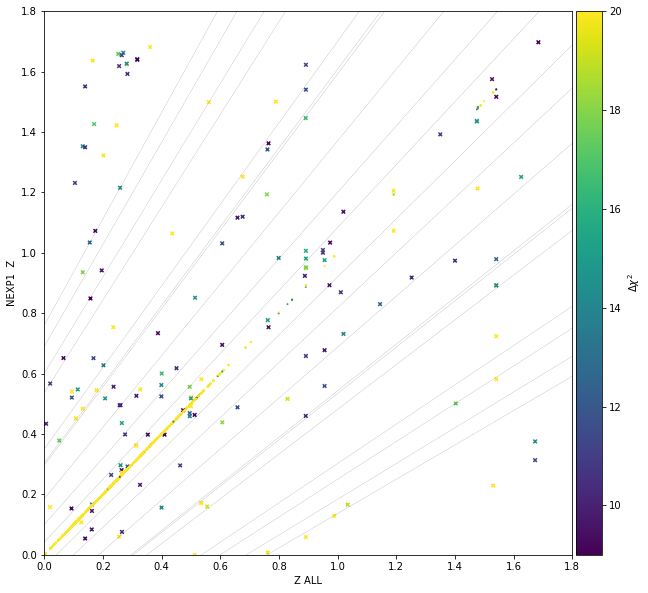

In [38]:
summary(keep, ones)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

deltav_plot(keep, ones, axes[0])
deltav_plot(keep, twos, axes[1])

In [ ]:
summary(keep, twos)

## Keep Tiles for which we have NEXP of 2, 4 and ALL.

In [ ]:
tile          = 70500
night         = '20200303'

keep          = results[tile][night]
keys          = keep.keys()

In [ ]:
ones          = ['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936']
twos          = ['NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4']
fours         = ['NEXP4-0', 'NEXP4-1']

In [ ]:
summary(keep, ones)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

deltav_plot(keep, ones, axes[0])
deltav_plot(keep, twos, axes[1])

In [ ]:
summary(keep, twos)

##  Example of coadded flux

In [ ]:
def bestfit_compare(i, ax, zbests, coadds_flux):    
    zbest    = Table(zbests)[i]
    
    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()
    
    fulltype = (spectype, subtype)
    
    # print(z, zerr)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    # R      = Resolution(res)
    # txflux = R.dot(resample_flux(wave, twave, tflux))
    
    ax.plot(wave, coadds_flux[i,:], lw=1.0, label='z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(z, zerr, zwarn, spectype, subtype, dchi2))
    ax.plot(twave + 5.,            tflux, lw=1.0)
    # ax.plot( wave,              txflux, lw=1.0)

    ax.legend(loc=2, frameon=False)
    
    ax.set_xlim(3500., 10000.)
    ax.set_ylim(bottom = -2.5)

##  Done.